In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100 #rescale the target in k$

In [3]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()

In [4]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(
    regressor,
    data, 
    target, 
    cv=cv,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)

`cv`: là chiến lược kiểm định chéo, chia dữ liệu thành tập huấn luyện và tập kiểm tra   
`scoring='neg_mean_absolute_error`: chỉ số đánh giá hiệu suất mô hình, tính sai số tuyệt đối trung bình âm  
`return_train_score=True`: quy định xem có trả về điểm số (score) trên tập huấn luyện hay không.   
`n_jobs=2`: số lượng công việc chạy song sonh để thực hiện kiểm định chéo   
n_jobs=2 yêu cầu sử dụng 2 CPU (hoặc lõi) để chạy các tác vụ song song, giúp tăng tốc độ xử lý.
- Nếu n_jobs=-1, tất cả các CPU khả dụng sẽ được sử dụng.  
- Nếu n_jobs=1 (mặc định), không có xử lý song song.  



In [6]:
scores = pd.DataFrame()
scores[['train error', 'test error']] = -cv_results[
    ['train_score', 'test_score']
]

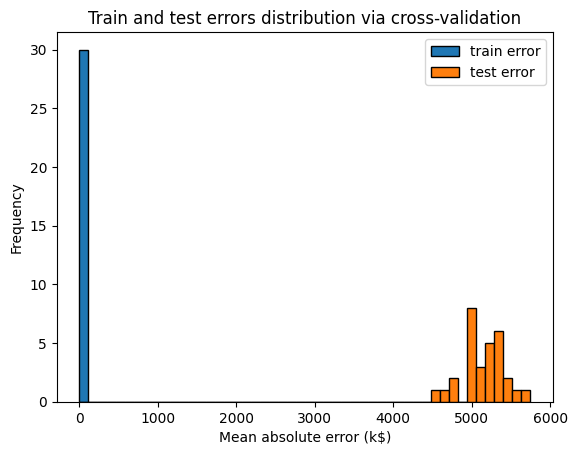

In [8]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor='black')
plt.xlabel('Mean absolute error (k$)')
_ = plt.title('Train and test errors distribution via cross-validation')

Mô hình đang bị overfit vì có thể thấy train error rất thấp (=0) trong khi đó test error lại rất cao 

### Validation curve (Đường cong xác thực)
Trong học máy, hyperparameter (siêu tham số) là những tham số ảnh hưởng tới kết quả học và dự đoán của mô hình. Ví dụ:
- Số lượng neighbors của k-nearest neighbors
- bậc của đa thức trong mô hình hồi quy đa thức  

Một số siêu tham số có thể là yếu tố quyết định underfit hoặc overfit. Để kiểm soát và hiểu ảnh hưởng của siêu tham số, ta sử dụng biểu đồ gọi là validation curve (đường cong xác thực)

Ví dụ về Decision Tree và `max_depth`

Trong mô hình cây quyết định, siêu tham số `max_depth` (độ sâu tối đa) dùn để điều chỉnh sự đánh đổi giữa overfit và underfit

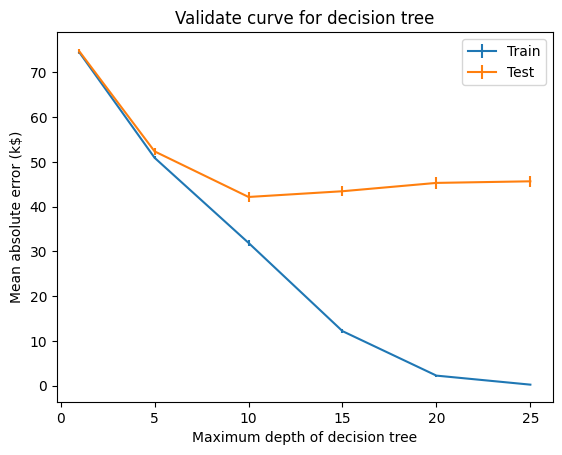

In [10]:
import numpy as np
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data, 
    target, 
    param_name='max_depth',
    param_range=max_depth,
    cv=cv,
    scoring='neg_mean_absolute_error',
    negate_score=True,
    std_display_style='errorbar',
    n_jobs=-1,
)

_ = disp.ax_.set(
    xlabel='Maximum depth of decision tree',
    ylabel='Mean absolute error (k$)',
    title='Validate curve for decision tree',
)

### Phân tích Validation Curve 
- max_depth < 10: mô hình underfit, Cả lỗi huấn luyện và kiểm tra đều cao -> mô hình quá đơn giản
- max_depth = 10: mô hình tổng quát hóa tốt nhất. Đủ linh hoạt để học được xu hướng tổng quát mà không học nhiễu
- max_depth > 10: mô hình overfit. Lỗi huấn luyện rất nhỏ nhưng lỗi kiểm tra tăng -> học cả nhiễu trong dữ liệu

*Lưu ý: Ngay cả max_depth = 10, mô hình vẫn có một chút overfit và underfit. Tuy nhiên, vì lỗi kiểm tra là nhỏ nhất ở đây -> đây là sự lựa chọn tốt nhất nếu chỉ tinh chỉnh 1 tham số.*

### Biến thể (variance) và độ lệch chuẩn 
Không nên chỉ nhìn và giá trị trung bình của lỗi. Cũng cần xem độ lệch chuẩn để hiểu mức độ dao động của lỗi. Nếu sai số có độ lệch chuẩn nhỏ -> kết luận đáng tin cậy hơn. 

### Nhiễu
Trong thực tế, dữ liệu có thể chứa nhiễu (noise) như: 
- Đo lường không chính xác từ cảm biến vật lý 
- Sai sót do con người ghi nhận dữ liệu 
- Không đo được những đặc trưng quan trọng (phổ biến nhất)

**Ví dụ**
Khi dự đoán nhà: 
- Diện tích -> đặc trưng dễ đo, liên quan trực tiếp tới giá
- Tâm lý người bán -> không đo được -> trơ thành nhiễu

-> Dữ liệu có thể có hai đặc trưng đầu vào giống hệt nhau nhưng có giá khác nhau là do yếu tố không quan sát được (nhiễu)

### Cách làm giảm ảnh hưởng của nhiễu
1. Chọn mô hình đơn giản hơn, hoặc tinh chỉnh siêu tham số cẩn thận 
2. Thu thập thêm dữ liệu có nhãn để cải thiện độ tổng quát hóa